In [1]:
import itertools
import numpy as np
'''
N = 16
#samples = np.reshape(np.array(list(itertools.product([0, 1], repeat=N))),(2**16, 4,4))
#data = np.load("result/sample_L4_10k_steps50000.npy")
#probs = np.exp(np.sum(np.sum(np.log(data), axis=2), axis=1))

store = []
store.append(samples)
store.append(probs)

config = np.zeros((2**16, 17, 4 ,4))
config_prob = np.zeros((2**16, 17))

for i in range (2**N):
    config[i][0] = samples[i]
    config_prob[i][0] = probs[i]
    for y in range (4):
        for x in range (4):
            if (samples[i][y][x] == 0):
                config[i][4*y+x+1] = samples[i+2**(4*(3-y)+(3-x))]
                config_prob[i][4*y+x+1] = probs[i+2**(4*(3-y)+(3-x))]
            else:
                config[i][4*y+x+1] = samples[i-2**(4*(3-y)+(3-x))]
                config_prob[i][4*y+x+1] = probs[i-2**(4*(3-y)+(3-x))]
'''                

'\nN = 16\n#samples = np.reshape(np.array(list(itertools.product([0, 1], repeat=N))),(2**16, 4,4))\n#data = np.load("result/sample_L4_10k_steps50000.npy")\n#probs = np.exp(np.sum(np.sum(np.log(data), axis=2), axis=1))\n\nstore = []\nstore.append(samples)\nstore.append(probs)\n\nconfig = np.zeros((2**16, 17, 4 ,4))\nconfig_prob = np.zeros((2**16, 17))\n\nfor i in range (2**N):\n    config[i][0] = samples[i]\n    config_prob[i][0] = probs[i]\n    for y in range (4):\n        for x in range (4):\n            if (samples[i][y][x] == 0):\n                config[i][4*y+x+1] = samples[i+2**(4*(3-y)+(3-x))]\n                config_prob[i][4*y+x+1] = probs[i+2**(4*(3-y)+(3-x))]\n            else:\n                config[i][4*y+x+1] = samples[i-2**(4*(3-y)+(3-x))]\n                config_prob[i][4*y+x+1] = probs[i-2**(4*(3-y)+(3-x))]\n'

In [2]:
def cond_label(position , L):
    '''
    Input
    position: 2d coordinate indicating the ith step
    L: the size of the lattice
    -----------------------
    Output
    The label of the lattice for each step (k)
    '''
    label = np.zeros((L, L))
    for i in range (position[0]):
        for j in range (L):
            label[i][j] = np.abs(i-position[0])+np.abs(j-position[1])
    if (position[0]%2 == 0):
        for j in range(position[1]):
            label[position[0]][j] = np.abs(j-position[1])
    else :
        for j in range(position[1], L):
            label[position[0]][j] = np.abs(j-position[1])
    return label

def binary_to_decimal(tensor):
    ans = 0
    for i in range (tensor.shape[0]):
        ans += 2**i*tensor[i]
    return ans

In [3]:

def ith_step(position, step, L, sample_, sample_prob_tensor_, choice): 
    # position: 2d coordinate indicating the ith step
    # k: how many steps in the cmi we want to conduct
    # L: the size of the lattice
    #num_sample_first = sample[:int(sample.shape[0]/1000)]
    #num_sample_second = sample[int(sample.shape[0]/1000):int(sample.shape[0]/1000)*2]
    #num_sample_first_prob = sample_prob_tensor[:int(sample.shape[0]/1000)]
    #num_sample_second_prob = sample_prob_tensor[int(sample_prob_tensor.shape[0]/1000):int(sample.shape[0]/1000)*2] #divide the sample into two
    
    sample_first = sample_[:10000]
    sample_second = sample_[10000:]
    sample_first_prob = sample_prob_tensor_[:10000]
    sample_second_prob = sample_prob_tensor_[10000:] #divide the sample into two
    if choice == "Euclidean":
        label, real_distance = distance_label(np.array(position), L)
    else: 
        label = label = cond_label(position, L)
    length = np.max(label)
    output = 0
    # get the coordinate that we need to match
    for i in range (1, step+1):
        pos_temp = np.where(label == i)
        label[pos_temp] = -1
   
    sample_category = []
    prob_category = []
    prob_category_expectation = []
    n = 2**len(np.where(label == -1)[0])   # the number of k
    
    for i in range (n):
        sample_category.append([]) 
        sample_category.append([])
        prob_category.append([])
        prob_category.append([])
        prob_category_expectation.append([0])
        prob_category_expectation.append([0]) # create size of 2*k because we also need to take x_i into account 
        
    for i in range (sample_second.shape[0]):
        temp = sample_second[i][np.where(label == -1)]  # sample category in binary
        num_label = binary_to_decimal(temp) #  sample category in digital
        
        if (sample_second[i][position[0]][position[1]] == 0): # divide even 2 more category with the two values of x_i
            sample_category[num_label].append(sample_second[i])
            prob_category[num_label].append(sample_second_prob[i])
        else:
            sample_category[num_label+n].append(sample_second[i])
            prob_category[num_label+n].append(sample_second_prob[i])
    '''
    for i in range (2*n):
        if len(sample_category[i]) == 0:
            print(i)
    '''
    for i in range (2*n):#calculate E_y{p(x_i|x_{i-1}....x_{i-k}y_{i-k-1}...y_1)} for each x_i-x_{i-k}
        if (len(prob_category[i]) == 0):
            prob_category_expectation[i] = 0.5
        for j in range (len(prob_category[i])):
            prob_category_expectation[i] += prob_category[i][j][position[0]][position[1]]/len(prob_category[i])
    #print(prob_category_expectation)
    for i in range (sample_first.shape[0]):
        #sampling from 1st to (i-1) th and output prob p(x_i|x_{i-1} x_{i-2}... x_1), this can be done directly.   

        num_label = binary_to_decimal(sample_first[i][np.where(label == -1)])
        
        
        if sample_first[i][position[0]][position[1]] == 0:
            output +=  np.abs(1 - prob_category_expectation[num_label]/sample_first_prob[i][position[0]][position[1]])
            
            #print(i, sample_first_prob[i][position[0]][position[1]], prob_category_expectation[num_label])
        else:
            output +=  np.abs(1 - prob_category_expectation[num_label+n]/sample_first_prob[i][position[0]][position[1]] )
            # easy direction: sampling from the 1st to some (i-2) and output prob p(x_i|x_{i-1}, y_{i-2}...y_1)
            # we first get y_1 ~ y_{i-2} samples and input the rnn with the known x_{i-1} and x_{i} to caluclate the output prob        
            # hard direction: sampling from the 1st to some (i-k) and output prob p(x_i|x_{i-1}, y_{i-k}...y_1)
            # we first get y_1 ~ y_{i-k} samples and input the rnn with the known x_{i-k+1} ~ x_{i} to calculate the output prob
            #  y_1 ~ y_{i-k} samples can be got by sampling y_1 ~ y_{i-2} and ignore the excess part.
    if choice =="Euclidean":
        return output/sample_first.shape[0], length, label, real_distance
    else:
        return output/sample_first.shape[0], length, label

In [4]:
def distance_label(A, L):   #B is tuple of array with size (|A|,2), 1st denotes the numbers of  points, 2nd denotes the coordinate.
    A_distance = np.zeros((L,L))*L**2  # denotes the distance between each lattice point and |A|
    dis_label = np.zeros((L,L))
    
    for i in range (A[0]):
        for j in range (L):
            if ( A_distance[i,j] < np.sqrt((i-A[0])**2 + (j-A[1])**2)):
                A_distance[i,j] = np.sqrt((i-A[0])**2 + (j-A[1])**2)
    if A[0]%2 == 0:
        for j in range(A[1]):
            if ( A_distance[A[0], j] < np.sqrt((j-A[1])**2)):
                A_distance[A[0],j] = np.sqrt((j-A[1])**2)
    elif A[0]%2 == 1:
        for j in range(L-A[1]-1):
            if ( A_distance[A[0], -j-1] < np.sqrt((L-j-1-A[1])**2)):
                A_distance[A[0],-j-1] = np.sqrt((L-j-1-A[1])**2)
    indices = np.squeeze(np.dstack(np.unravel_index(np.argsort(A_distance.ravel()), (L, L)))) 
    flat_indices = np.argsort(A_distance.ravel()) 
    # the 1st indice indicates the closet lattice points to B  
    temp = 0     # denotes the order
    count = []   # denote the number of lattice for each order
    temp_count = 1
    for i in range (L**2):
        if (i!=0):
            if (A_distance[indices[i][0],indices[i][1]]> A_distance[indices[i-1][0],indices[i-1][1]]):
                temp += 1
                count.append(temp_count)
                temp_count = 1
            else :
                temp_count +=1
        dis_label[indices[i][0],indices[i][1]] = temp
    count.append(temp_count)    
    temp = 0
    marginal_label = []
    for i in range (len(count)):
        temp1 = temp
        temp += count[i]
        marginal_label.append(flat_indices[temp1:temp])
    
    return dis_label, A_distance   # reverse 

def cond_label(position , L):
    '''
    Input
    position: 2d coordinate indicating the ith step
    L: the size of the lattice
    -----------------------
    Output
    The label of the lattice for each step (k)
    '''
    label = np.zeros((L, L))
    for i in range (position[0]):
        for j in range (L):
            label[i][j] = np.abs(i-position[0])+np.abs(j-position[1])
    if (position[0]%2 == 0):
        for j in range(position[1]):
            label[position[0]][j] = np.abs(j-position[1])
    else :
        for j in range(position[1], L):
            label[position[0]][j] = np.abs(j-position[1])
    #label[position[0]][position[1]] = -1
    return label

test = cond_label([3,3], 12)
test_1 = distance_label(np.array([3,3]),12)
print(test)
print(test_1)


[[ 6.  5.  4.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 5.  4.  3.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 4.  3.  2.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
(array([[11.,  8.,  7.,  6.,  7.,  8., 11., 13., 16., 20., 24., 28.],
       [ 8.,  5.,  4.,  3.,  4.,  5.,  8., 12., 15., 19., 23., 27.],
       [ 7.,  4.,  2.,  1.,  2.,  4.,  7., 10., 14., 18., 22., 26.],
       [ 0.,  0.,  0.,  0.,  1.,  3.,  6.,  9., 13., 17., 21., 25.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.

In [5]:
import os
os.getcwd()

'C:\\Users\\Administrator\\PycharmProjects\\RNNWavefunctions'

In [5]:

sample = np.load("2DJ1J2/result/sample_L10_40k_steps26015.npy")
sample = np.transpose(sample, (0,2,1))

sample_prob_tensor = np.load("2DJ1J2/result/sample_cond_prob_L10_40k_steps26015.npy")
sample_prob_tensor = np.transpose(sample_prob_tensor, (0,2,1))


print(sample_prob_tensor)
print(sample)

[[[0.5013095  0.6473838  0.6047374  ... 0.6123667  0.3821392  0.66497344]
  [0.39748174 0.522237   0.251429   ... 0.6318023  0.47746322 0.2910865 ]
  [0.80860466 0.7249814  0.1753141  ... 0.5888818  0.26588845 0.9316385 ]
  ...
  [0.6547289  0.43437386 0.24348325 ... 0.5731839  0.3412564  0.3506565 ]
  [0.7236403  0.83353966 0.18738283 ... 0.25928834 0.56285137 0.9335954 ]
  [0.72322804 0.54721266 0.7087053  ... 0.20611    0.9182247  0.52310306]]

 [[0.5013095  0.6473838  0.39526254 ... 0.37676752 0.66668236 0.61372274]
  [0.81557816 0.65123856 0.748675   ... 0.20289391 0.7318007  0.73325264]
  [0.54684526 0.69510764 0.5065663  ... 0.8726754  0.38821647 0.665869  ]
  ...
  [0.6873046  0.43564236 0.66690665 ... 0.845394   0.41162637 0.8639249 ]
  [0.2834761  0.49299937 0.5321377  ... 0.6294565  0.8093127  0.46943367]
  [0.9087891  0.82407105 0.86999756 ... 0.8563017  0.646657   0.75583285]]

 [[0.49869043 0.35377502 0.34268695 ... 0.39725572 0.6608036  0.6199281 ]
  [0.8949908  0.239791

In [8]:

position = [5, 5]
L = 10
prob_diff, length, label = ith_step(position, 3, L, sample, sample_prob_tensor, "else")
label 



array([[10.,  9.,  8.,  7.,  6.,  5.,  6.,  7.,  8.,  9.],
       [ 9.,  8.,  7.,  6.,  5.,  4.,  5.,  6.,  7.,  8.],
       [ 8.,  7.,  6.,  5.,  4., -1.,  4.,  5.,  6.,  7.],
       [ 7.,  6.,  5.,  4., -1., -1., -1.,  4.,  5.,  6.],
       [ 6.,  5.,  4., -1., -1., -1., -1., -1.,  4.,  5.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [9]:
print(prob_diff)

[0.06928504]


In [ ]:
isize = 0
result = []

for i in range (L-1):
    if (isize + len(np.where(distance_label(position, L) == i+1)[0])<=16):
        isize += len(np.where(distance_label(position, L) == i+1)[0])
    else: 
        break
diff = np.zeros(i)   
for i in range (len(diff)):
    diff[i] = ith_step(position, i, L, sample, sample_prob_tensor, "else")[0]
   


In [11]:
isize = 0
result = []
for y in range (2, L):
    for x in range(L):
        isize = 0
        position = [y ,x]
        for i in range (L-1):
            if (isize + len(np.where(cond_label(position, L) == i+1)[0])<=20):
                isize += len(np.where(cond_label(position, L) == i+1)[0])
            else: 
                break
        diff = np.zeros(i)   
        for i in range (len(diff)):
            diff[i] = ith_step(position, i, L, sample, sample_prob_tensor, " else ")[0]
        print(diff)    
        result.append(diff)


[0.28487483 0.20988545 0.06469833 0.02358385 0.0101442  0.00394331
 0.00251352 0.00649386]
[0.34626115 0.20377024 0.10524355 0.01743794 0.00757684 0.00432459
 0.0091275  0.03534677]
[0.32205711 0.19513938 0.09275635 0.04293255 0.0125422  0.02065103
 0.05272795]
[0.32366064 0.19431453 0.0923245  0.03748153 0.03242014 0.08545641]
[0.32040846 0.19366045 0.09115538 0.03617142 0.04414119]
[0.32091843 0.19839788 0.0903722  0.03688535]
[0.32941886 0.19217137 0.08836947 0.0358677  0.05325823]
[0.31928531 0.19132651 0.08580887 0.03772019 0.02811722]
[0.3078962  0.18670863 0.09051414 0.02976515 0.01446838 0.03553659]
[0.37936522 0.22970172 0.10128705 0.03872469 0.01625389 0.0196863
 0.07257257]
[0.41912458 0.2181484  0.13339737 0.08056859 0.04544389]
[0.33117339 0.17617918 0.10191936 0.0780151  0.05985086]
[0.34834339 0.17689228 0.09987628 0.07464015]
[0.34475203 0.1724041  0.09958378 0.07233413]
[0.33320055 0.17634992 0.09861521 0.07384414]
[0.34164632 0.17130924 0.09755401 0.07118311]
[0.34474

In [61]:
j = 2
i = 1
print(result[0:5][:4])


[array([0.12943783, 0.09887462, 0.03637864, 0.01744456, 0.01299987,
       0.00971266, 0.00957928, 0.00972019, 0.01612038, 0.03977159]), array([0.52552016, 0.08136941, 0.04055691, 0.02445147, 0.00944863,
       0.02165249, 0.05451776, 0.13978544, 0.24602336]), array([0.22502688, 0.09043572, 0.05388328, 0.01333813, 0.02004551,
       0.04119247, 0.08495894]), array([0.07944841, 0.05874285, 0.0387072 , 0.02295726, 0.01933378,
       0.04113223])]


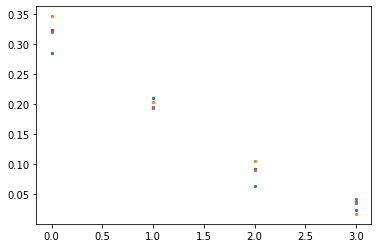

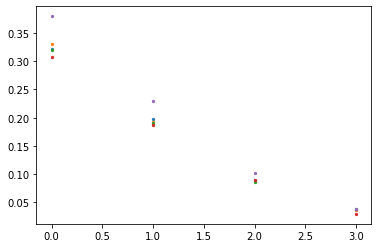

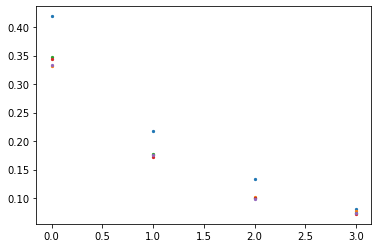

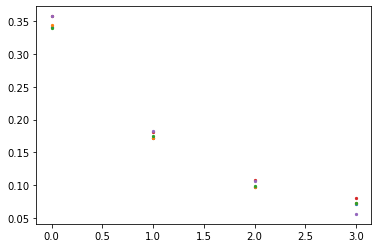

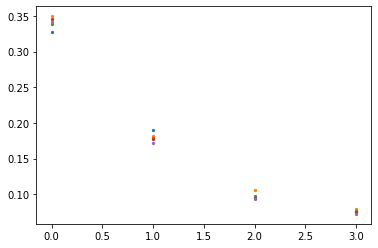

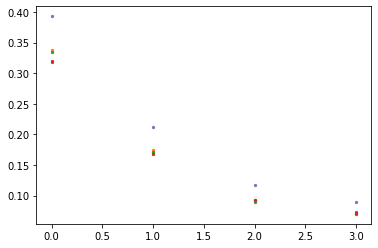

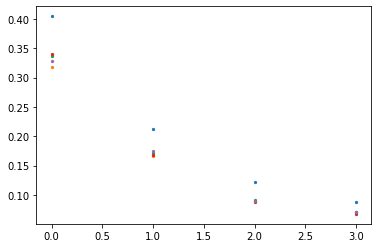

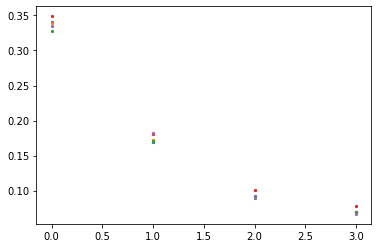

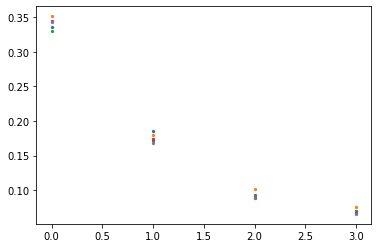

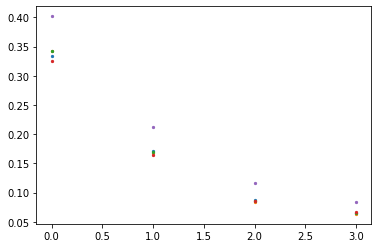

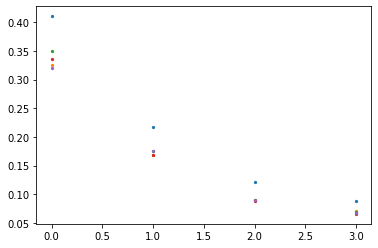

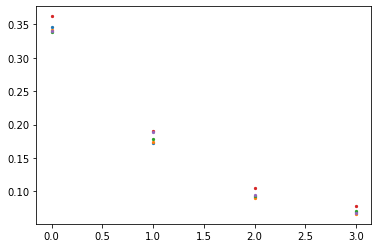

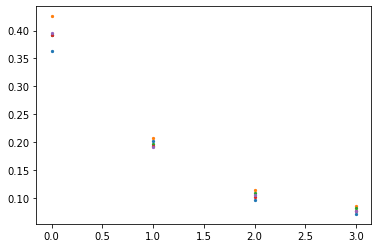

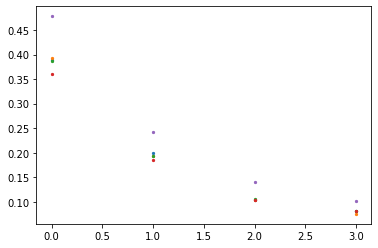

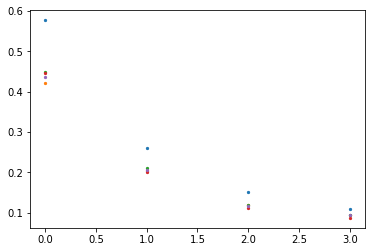

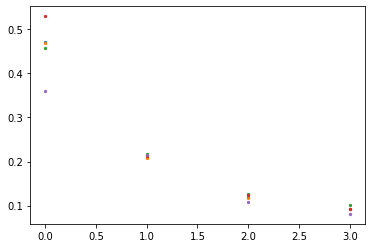

In [13]:

import matplotlib.pyplot as plt
for j in range (len(result)//5):
    for i in range (5):
        plt.scatter(np.arange(4), (result[5*j+i][:4]), s=5)
    plt.savefig("figure_J1J2/TV_"+str(5*j)+".png", dpi = 200)
    plt.show()

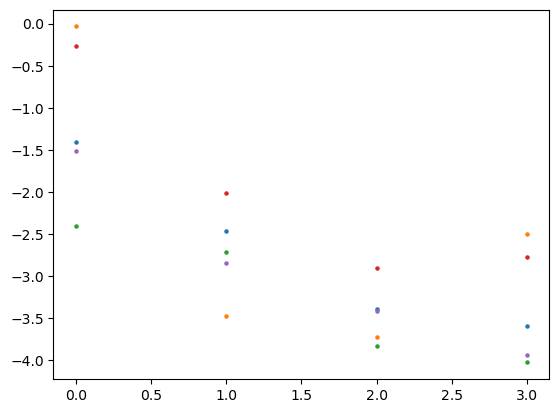

In [32]:
for i in range (110, 115):
    plt.scatter(np.arange(4), np.log(result[i][:4]), s=5)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


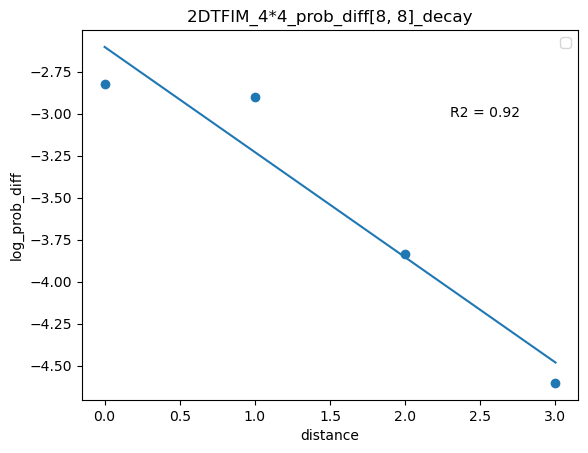

In [20]:
x = np.arange(len(diff))
y = np.log(diff)
import matplotlib.pyplot as plt

a, b = np.polyfit(x, y, 1)
r2 = 1 - np.sum((a*x+b-y)**2) \
/np.sum((y - np.mean(y))**2)
plt.scatter(x, y)
plt.plot(x, a*x+b)
plt.figtext(0.7,0.7,'R2 = ' + str(np.round(r2,3)))
plt.xlabel("distance")
plt.ylabel("log_prob_diff")
plt.title("2DTFIM_4*4_prob_diff"+str(position)+"_decay")
plt.legend()
plt.savefig("2DHeisenberg_x4y4_31_prob_diff_decay.png", dpi = 250)
plt.show()

In [9]:
a = [[]]*3
a[0].append([[2,4,5,6,7],[1,2,3,4,5]])
print(a)

[[[[2, 4, 5, 6, 7], [1, 2, 3, 4, 5]]], [[[2, 4, 5, 6, 7], [1, 2, 3, 4, 5]]], [[[2, 4, 5, 6, 7], [1, 2, 3, 4, 5]]]]


In [10]:
sample_category = [[]]*4
sample_category[0].append([[1, 1, 1, 1, 1, 1], [1, 0, 1, 0, 0, 1], [1, 1, 1, 1, 0, 0], [0, 1, 0, 1, 0, 0]])
print(sample_category)

[[[[1, 1, 1, 1, 1, 1], [1, 0, 1, 0, 0, 1], [1, 1, 1, 1, 0, 0], [0, 1, 0, 1, 0, 0]]], [[[1, 1, 1, 1, 1, 1], [1, 0, 1, 0, 0, 1], [1, 1, 1, 1, 0, 0], [0, 1, 0, 1, 0, 0]]], [[[1, 1, 1, 1, 1, 1], [1, 0, 1, 0, 0, 1], [1, 1, 1, 1, 0, 0], [0, 1, 0, 1, 0, 0]]], [[[1, 1, 1, 1, 1, 1], [1, 0, 1, 0, 0, 1], [1, 1, 1, 1, 0, 0], [0, 1, 0, 1, 0, 0]]]]


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import graph_util
Nx = 4
Ny = 4

graph = tf.get_default_graph()
input_graph_def = graph.as_graph_def()
   
with tf.Session() as sess: 
#First let's load meta graph and restore weights
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    saver = tf.train.import_meta_graph('../Check_Points/2DTFIM/RNNwavefunction_2DVanillaRNN_4x4_Bx3_lradap0.005_samp500units_100.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint("../Check_Points/2DTFIM/"))

    
    log_prob = graph.get_tensor_by_name('log_prob:0')
    sample_placeholder = graph.get_tensor_by_name('sample_placeholder:0')
    samples = graph.get_tensor_by_name('samples:0')
    
    feed_dict = {placeholder: np.zeros((20,4,4))}
    sample_ = sess.run(samples, )
print(log_prob_tensor)    

In [10]:
test = np.load("result/sample_cond_prob_L4_10k_steps28.npy")
print(test)

[[[0.5314115  0.7288914  0.42850736 1.        ]
  [0.5308155  0.6533904  0.5708922  0.6928279 ]
  [0.5479541  0.71796036 0.69150156 0.7660212 ]
  [0.45616123 0.45414433 0.7583107  0.571269  ]]

 [[0.46858844 0.65226144 0.44093016 1.        ]
  [0.54569006 0.5624183  0.4719576  1.        ]
  [0.4628068  0.7168896  0.46342775 1.        ]
  [0.45537326 0.45255768 1.         1.        ]]

 [[0.5314115  0.72075766 0.43292126 1.        ]
  [0.5308155  0.47429386 0.4335434  0.41457084]
  [0.4520459  0.6454629  0.75759375 0.52441794]
  [0.54833215 0.5469131  0.66679263 0.43601808]]

 ...

 [[0.46858844 0.52993083 0.4241288  1.        ]
  [0.54569006 0.4419277  0.56110805 1.        ]
  [0.5371932  0.5296184  0.3140014  1.        ]
  [0.546577   0.45148376 0.5526988  1.        ]]

 [[0.5314115  0.5657249  0.57076645 1.        ]
  [0.4691845  0.73162997 0.47206104 1.        ]
  [0.4614644  0.28299367 1.         1.        ]
  [0.4534682  0.45379475 1.         1.        ]]

 [[0.5314115  0.72450006